In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 1e-4
timesteps = 1000
beta_start = 1e-4
beta_end = 0.02

2024-07-12 06:19:22.914376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 06:19:22.931730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 06:19:22.931771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 06:19:22.944240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


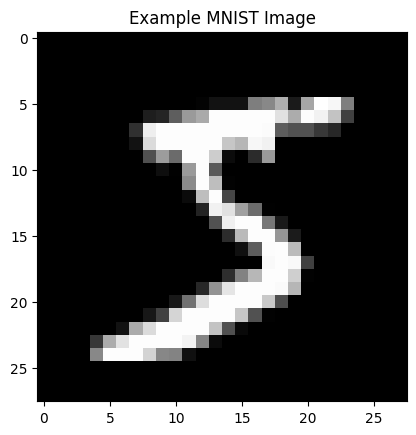

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = x_train[..., tf.newaxis]  # Add channel dimension for grayscale
x_test = x_test[..., tf.newaxis]

# Print data shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# Display an example image from the training set
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.title("Example MNIST Image")
plt.show()

In [3]:
# Define the model using the functional API
inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape((28, 28, 1))(outputs)

model = tf.keras.Model(inputs, outputs)

# Print model summary
model.summary()

2024-07-12 06:19:25.126279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,984,528 (99.12 MB)

 Trainable params: 25,984,528 (99.12 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define betas and alphas
betas = tf.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_bar = tf.math.cumprod(alphas)

# Print beta and alpha shapes
print(f"betas shape: {betas.shape}")
print(f"alphas shape: {alphas.shape}")
print(f"alphas_bar shape: {alphas_bar.shape}")

betas shape: (1000,)
alphas shape: (1000,)
alphas_bar shape: (1000,)


In [5]:
# Function to add noise to the data
def add_noise(x, t):
    noise = tf.random.normal(shape=tf.shape(x))
    alpha_bar = tf.gather(alphas_bar, t)
    return tf.sqrt(alpha_bar)[..., None, None, None] * x + tf.sqrt(1 - alpha_bar)[..., None, None, None] * noise, noise

In [6]:
class SimpleDDPM(tf.keras.Model):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = model

    def train_step(self, data):
        x = data
        t = tf.random.uniform(shape=[tf.shape(x)[0]], minval=0, maxval=timesteps, dtype=tf.int32)
        x_noisy, true_noise = add_noise(x, t)

        with tf.GradientTape() as tape:
            predicted_noise = self.model(x_noisy)
            loss = tf.keras.losses.MeanSquaredError()(predicted_noise, true_noise)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return {"loss": loss}

# Instantiate the model
ddpm_model = SimpleDDPM()
ddpm_model.compile(optimizer=optimizer)

In [ ]:
# Train the model
num_epochs = 100
ddpm_model.fit(x_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9742
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9741
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9738
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9743
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9741
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9741
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9741
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9740
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9742
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9740
Epoch 11/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9736
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9732
Epoch 13/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9731
Epoch 14/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9730
Epoch 15/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3

Generated images shape: (10, 28, 28, 1)


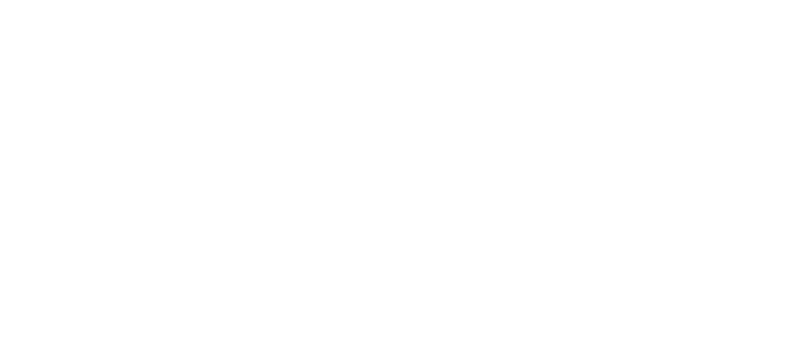

In [9]:
# Generate images
def generate_images(num_images=10):
    noise = tf.random.normal(shape=[num_images, 28, 28, 1])
    for t in reversed(range(timesteps)):
        predicted_noise = model(noise)
        alpha_bar = tf.gather(alphas_bar, t)
        noise = tf.sqrt(alpha_bar)[..., None, None, None] * noise + tf.sqrt(1 - alpha_bar)[..., None, None, None] * predicted_noise

    images = tf.clip_by_value(noise, 0.0, 1.0)
    return images

# Generate and visualize images
generated_images = generate_images()
print(f"Generated images shape: {generated_images.shape}")
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    axs[i // 5, i % 5].imshow(generated_images[i][..., 0], cmap='gray')
    axs[i // 5, i % 5].axis('off')
plt.show()